# 전이 학습(Transfer Learning)
### CIFAR-10 이미지 분류
---

### 필요한 라이브러리 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### 데이터 준비

In [ ]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape, X_test.shape)

170498071/170498071 [==============================] - 13s 0us/step
(50000, 32, 32, 3) (10000, 32, 32, 3)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True)

In [ ]:
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(35000, 32, 32, 3) (15000, 32, 32, 3)
(35000, 1) (15000, 1)


### 정규화

In [ ]:
X_train = X_train.astype('float32')/255.
X_val = X_val.astype('float32')/255.
X_test = X_test.astype('float32')/255.

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_oh = to_categorical(y_train)
y_val_oh = to_categorical(y_val)
y_test_oh = to_categorical(y_test)

### 모델링(Modeling)
- pre-trained VGG-16
  - weights: ImageNet 데이터로 학습된 모델
  - include_top: 상단의 FC layer를 포함할지 여부
- `.trainable = False`: Feature Extraction은 사전 학습된 모델의 파라미터를 재사용

In [ ]:
from tensorflow.keras.applications import VGG16

base = VGG16(weights='imagenet', input_shape=(32, 32, 3), 
             include_top=False)
base.trainable = False
base.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [ ]:
model = keras.Sequential([
    base, 
    layers.Flatten(), 
    layers.Dropout(0.2), 
    layers.Dense(64, activation='relu'), 
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['acc']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 14,748,170
Trainable params: 33,482
Non-trainable params: 14,714,688
_________________________________________________________________


### 학습(Training)

In [ ]:
EPOCHS = 100
BATCH_SIZE = 64

log = model.fit(X_train, y_train_oh, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                validation_data=[X_val, y_val_oh], 
                verbose=1)

Epoch 1/100
547/547 [==============================] - 19s 17ms/step - loss: 1.5962 - acc: 0.4417 - val_loss: 1.3515 - val_acc: 0.5344
Epoch 2/100
547/547 [==============================] - 8s 15ms/step - loss: 1.3828 - acc: 0.5180 - val_loss: 1.2856 - val_acc: 0.5590
Epoch 3/100
547/547 [==============================] - 9s 16ms/step - loss: 1.3472 - acc: 0.5308 - val_loss: 1.2678 - val_acc: 0.5598
Epoch 4/100
547/547 [==============================] - 8s 15ms/step - loss: 1.3257 - acc: 0.5385 - val_loss: 1.2478 - val_acc: 0.5653
Epoch 5/100
547/547 [==============================] - 8s 15ms/step - loss: 1.3045 - acc: 0.5446 - val_loss: 1.2419 - val_acc: 0.5676
Epoch 6/100
547/547 [==============================] - 8s 15ms/step - loss: 1.2893 - acc: 0.5486 - val_loss: 1.2332 - val_acc: 0.5737
Epoch 7/100
547/547 [==============================] - 8s 15ms/step - loss: 1.2781 - acc: 0.5521 - val_loss: 1.2305 - val_acc: 0.5689
Epoch 8/100
547/547 [==============================] - 8s 15m

- 학습 과정 시각화

In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(16,8))
    
    plt.subplot(1,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='Val Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'], label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_acc'], label='Val Accuracy')
    plt.legend()

    plt.show()

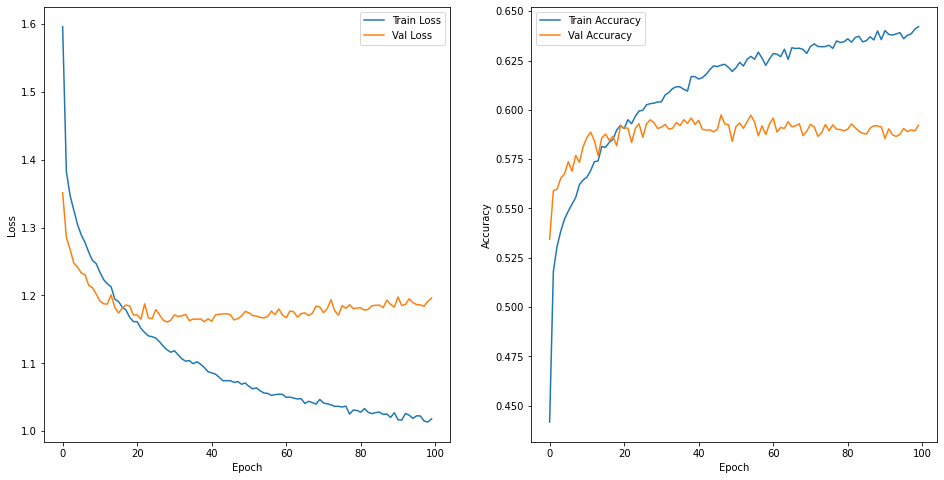

In [ ]:
plot_history(log)

### 평가(Evaluation)

In [ ]:
model.evaluate(X_test, y_test_oh)

313/313 [==============================] - 3s 9ms/step - loss: 1.2098 - acc: 0.5850


[1.209812879562378, 0.5849999785423279]

### 예측(Prediction)

In [ ]:
y_pred = model.predict(X_test)
y_pred[:5]

313/313 [==============================] - 2s 7ms/step


array([[4.39873664e-03, 2.20687181e-01, 3.05898674e-02, 4.24698263e-01,
        1.59587879e-02, 1.47326678e-01, 1.82423946e-02, 1.30510284e-02,
        2.64097024e-02, 9.86374021e-02],
       [3.94606683e-03, 1.09603517e-01, 9.04469562e-06, 4.84869051e-05,
        5.88440162e-06, 3.07627010e-06, 1.41297778e-05, 7.91795003e-08,
        8.85071516e-01, 1.29816984e-03],
       [2.68240068e-02, 2.81727761e-02, 2.45316210e-03, 2.83019361e-03,
        1.56533737e-02, 7.54481822e-04, 3.06367001e-05, 3.85458767e-03,
        8.92814755e-01, 2.66119670e-02],
       [4.24472034e-01, 2.04436421e-01, 9.40592773e-03, 2.78404597e-02,
        4.59173112e-04, 8.31600279e-03, 7.76139728e-04, 2.02197139e-03,
        1.71295092e-01, 1.50976732e-01],
       [2.14338390e-04, 3.20149229e-05, 1.54744819e-01, 1.39098335e-02,
        4.00198018e-03, 2.69389548e-03, 8.24190140e-01, 6.80322337e-05,
        7.33657580e-05, 7.15420247e-05]], dtype=float32)

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_pred[:5]

array([3, 8, 8, 0, 6])

- 혼동 행렬(confusion matrix)

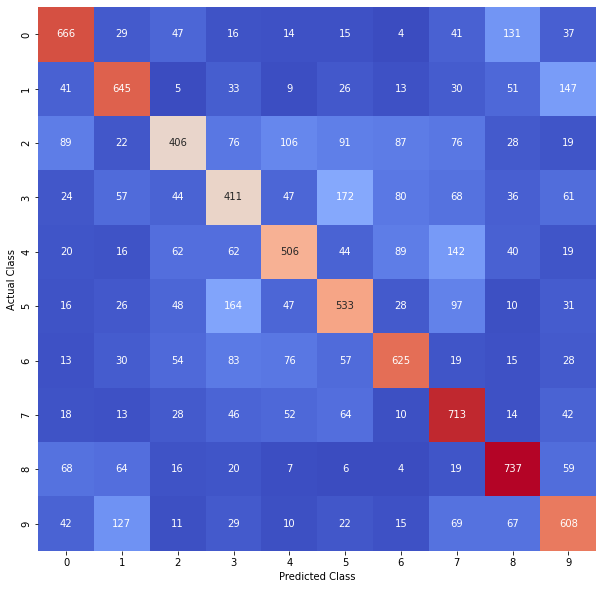

In [ ]:
from sklearn.metrics import confusion_matrix

cfm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cfm, annot=True, cbar=False, cmap='coolwarm', fmt='d')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

CNN 사전학습 모델(pre-trained model)
- LeNet
- AlexNet
- VGGNet
- InceptionNet
- ResNet 
- DenseNet
- MobileNet
- EfficientNet